In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import nibabel as nib
T1w_img = nib.load('991267-T1w_acpc_dc.nii.gz')
T1w_data = T1w_img.get_data()

(-0.5, 310.5, 259.5, -0.5)

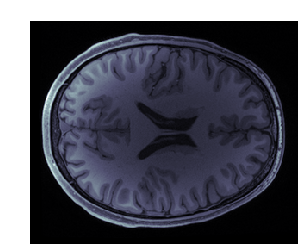

In [4]:
fig, ax = plt.subplots(1)
ax.matshow(T1w_data[:, :, T1w_data.shape[-1]//2], cmap='bone')
ax.axis('off')

There seem to be some global image data has some biases in the image (for example, the white matter in the center seems to be particulary dark, relative to the outside), so we will start by detrending the data (note: in MRI 'detrending' is often used to refer to temporal detrending. Here, we are doing a spatial detrending!)

In [5]:
T1w_data.shape

(260, 311, 260)

In [6]:
x,y,z = np.meshgrid(range(-T1w_data.shape[0]//2, T1w_data.shape[0]//2),
                    range(-T1w_data.shape[1]//2, T1w_data.shape[1]//2),
                    range(-T1w_data.shape[2]//2, T1w_data.shape[2]//2), indexing='ij')


In [7]:
x.shape, y.shape, z.shape

((260, 311, 260), (260, 311, 260), (260, 311, 260))

In [8]:
def show_volumes(volume_list):
    """ 
    Helper function to show several volumes together
    """
    fig, ax = plt.subplots(1, len(volume_list))
    for idx in range(len(volume_list)):
        this = volume_list[idx]
        ax[idx].matshow(this[:, :, this.shape[-1]//2], cmap='bone')
        ax[idx].axis('off')
    fig.set_size_inches([14, 4])
    return fig

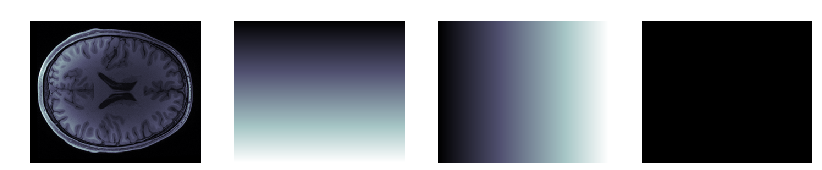

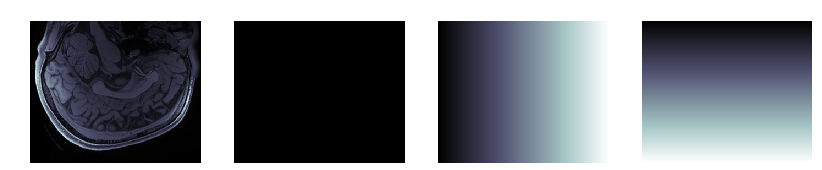

In [9]:
fig1 = show_volumes([T1w_data, x, y, z])
fig1.savefig('../fig/detrending01.png')
fig2 = show_volumes([T1w_data.T, x.T, y.T, z.T])
fig2.savefig('../fig/detrending02.png')

In [10]:
a = np.arange(1000).reshape((10, 10, 10))

In [11]:
a[0,0,0], a[0,0,1]

(0, 1)

In [12]:
a.ravel()[0], a.ravel()[1]

(0, 1)

To identify the trends in the data, we will try to solve the following equation for $\beta$:

${\bf y}= {\bf X}\beta$, 

where ${\bf y}$ is the image data, ${\bf X}$ are the linear trends, and $\beta$ are the amount of this linear trend across the image (in 3D)

We construct a design matrix for this problem with the different linear trends (along each spatial axis): 

We linearize the data as well:

In [13]:
regressors = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
data = T1w_data.ravel()
data.shape, regressors.shape

((21023600,), (21023600, 3))

$$ \begin{pmatrix}
T1_{0,0,0} \\
T1_{0,0,1} \\
\vdots \\
T1_{0, 0, N_z} \\
T1_{0, 1, 0} \\
T1_{0,1,1} \\
\vdots \\
T1_{1,0,0} \\
T1_{1,0,1} \\
\vdots \\
T1_{N_x, N_y, N_z} \end{pmatrix} =
\begin{pmatrix}
x_{0,0,0} & y_{0,0,0} & z_{0,0,0} \\
x_{0,0,1} & y_{0,0,1} & z_{0,0,1}\\
\vdots & \vdots & \vdots \\
x_{0, 0, N_z} & y_{0, 0, N_z} & z_{0, 0, N_z} \\
x_{0, 1, 0} & y_{0, 1, 0} & z_{0, 1, 0} \\
x_{0,1,1} & y_{0,1,1} & z_{0,1,1} \\
\vdots & \vdots & \vdots \\
x_{1,0,0} & y_{1,0,0} & z_{1,0,0} \\
x_{1,0,1} & y_{1,0,1} & z_{1,0,1}\\
\vdots & \vdots & \vdots \\
x_{N_x, N_y, N_z} & y_{N_x, N_y, N_z} & z_{N_x, N_y, N_z}
\end{pmatrix} \begin{pmatrix} \beta_1 \\ \beta_2 \\ \beta_3 \end{pmatrix}
$$


In [14]:
import scipy.linalg as la
#la.lstsq?

In [15]:
solution = la.lstsq(regressors, data)

In [16]:
beta_hat = solution[0]

In [17]:
linear_trend = np.dot(regressors, beta_hat)

In [18]:
linear_trend.shape

(21023600,)

In [19]:
linear_trend = np.reshape(linear_trend, T1w_data.shape)

In [20]:
T1w_linear_detrend = T1w_data - linear_trend

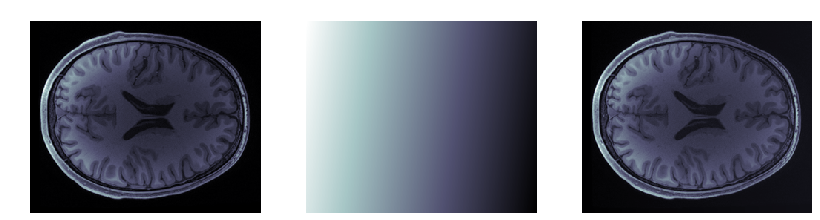

In [21]:
fig = show_volumes([T1w_data, linear_trend, T1w_linear_detrend])
fig.savefig('../fig/detrending03.png')

Let's write a function to codify this entire process:

In [22]:
def detrend(data, regressors):
    regressors = np.vstack([r.ravel() for r in regressors]).T
    solution = la.lstsq(regressors, data.ravel())
    beta_hat = solution[0]
    trend = np.dot(regressors, beta_hat)
    detrended = data - np.reshape(trend, data.shape)
    return detrended, beta_hat
    

In [23]:
T1w_linear_detrend, beta_hat = detrend(T1w_data, [x, y, z])

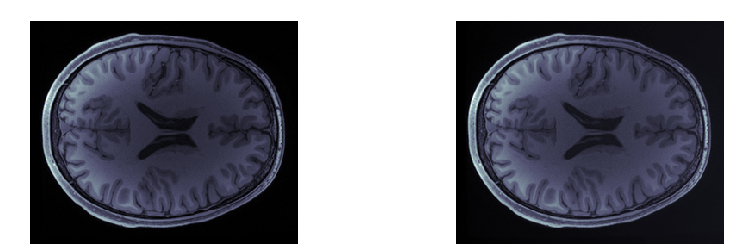

In [24]:
fig = show_volumes([T1w_data, T1w_linear_detrend])
fig.savefig('../fig/detrending04.png')

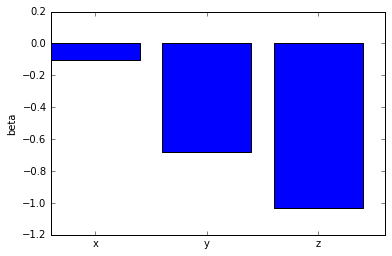

In [25]:
fig, ax = plt.subplots()
ax.bar(np.arange(beta_hat.shape[0]), beta_hat)
ax.set_xticks(np.arange(beta_hat.shape[0]) + 0.4)
ax.set_xticklabels(['x', 'y', 'z'])
ax.set_ylabel('beta')
fig.savefig('../fig/detrending05.png')

In [26]:
x_sq = x**2
y_sq = y**2
z_sq = z**2

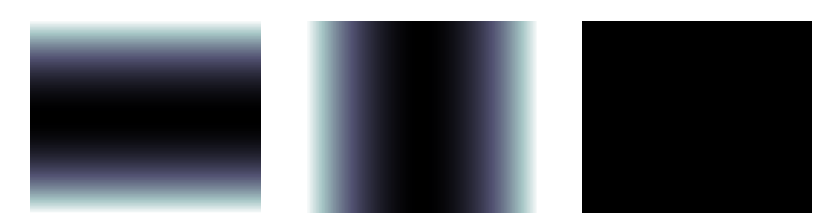

In [27]:
fig = show_volumes([x_sq, y_sq, z_sq])
fig.savefig('../fig/detrending06.png')

In [28]:
T1w_data_detrended_quad, beta_hat = detrend(T1w_data, [x, y, z, x_sq, y_sq, z_sq])

In [34]:
quadratic_trend = np.dot(beta_hat, [r.ravel() for r in [x, y, z, x_sq, y_sq, z_sq]]).reshape(T1w_data.shape)

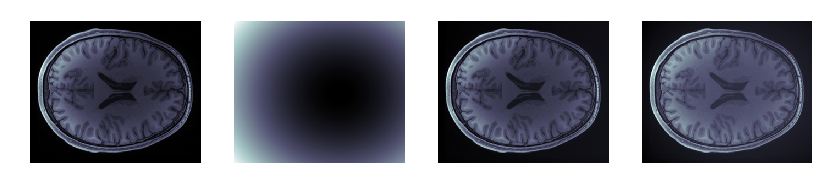

In [35]:
fig = show_volumes([T1w_data, quadratic_trend, T1w_linear_detrend, T1w_data_detrended_quad])
fig.savefig('../fig/detrending07.png')

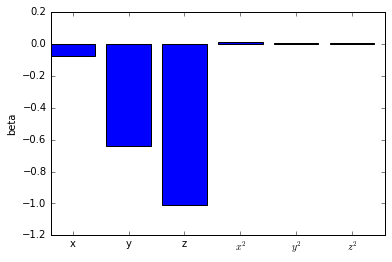

In [36]:
fig, ax = plt.subplots()
ax.bar(np.arange(beta_hat.shape[0]), beta_hat)
ax.set_xticks(np.arange(beta_hat.shape[0]) + 0.4)
ax.set_xticklabels(['x', 'y', 'z', '$x^2$', '$y^2$', '$z^2$'])
ax.set_ylabel('beta')
fig.savefig('../fig/detrending08.png')

In [37]:
# hist, bin_centers = histogram(image.ravel(), nbins)
# hist = hist.astype(float)

# # class probabilities for all possible thresholds
# weight1 = np.cumsum(hist)
# weight2 = np.cumsum(hist[::-1])[::-1]

# # class means for all possible thresholds
# mean1 = np.cumsum(hist * bin_centers) / weight1
# mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]

# # Clip ends to align class 1 and class 2 variables:
# # The last value of `weight1`/`mean1` should pair with zero values in
# # `weight2`/`mean2`, which do not exist.
# variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

# idx = np.argmax(variance12)
# threshold = bin_centers[:-1][idx]



In [ ]:
#thresh = filt.threshold_otsu(T1w_data)

In [ ]:
#binary = T1w_data >= thresh

In [ ]:
#plt.matshow(binary[:, :, binary.shape[-1]//2], cmap='bone')